In [1]:
%matplotlib inline

In [2]:
# %% ----- package imports
import matplotlib.pyplot as plt
import numpy as np
import clipboard_and_style_sheet as cr
import tables
import pynlo_extras as pe
from scipy.integrate import simpson


In [3]:
c = 299792458.0
pJ = 1e-12
nm = 1e-9
ps = 1e-12
W = 1e3

# nm, pJ/nm, rad
spectrum = np.genfromtxt("../210526_2.0W_spectrum.txt", skip_header=1)
spectrum[:, 0] = c / (spectrum[:, 0] * nm)
spectrum[:, 1] *= pJ / nm

# ps, W, rad
time = np.genfromtxt("../210526_2.0W_pulse.txt", skip_header=1)
time[:, 0] *= ps
time[:, 1] *= W

atom = tables.Float64Atom()
file = tables.open_file("../210526_2.0W_pulse.h5", "w")

file.create_array(where=file.root, name="v_grid", atom=atom, obj=spectrum[:, 0])
file.create_array(where=file.root, name="p_v", atom=atom, obj=spectrum[:, 1])
file.create_array(where=file.root, name="phi_v", atom=atom, obj=spectrum[:, 2])

file.create_array(where=file.root, name="t_grid", atom=atom, obj=time[:, 0])
file.create_array(where=file.root, name="p_t", atom=atom, obj=time[:, 1])
file.create_array(where=file.root, name="phi_t", atom=atom, obj=time[:, 2])

file.close()

In [5]:
c = 299792458

n_points = 2**10
min_wl = 800e-9
max_wl = 3e-6
center_wl = 1550e-9
t_fwhm = 50e-15
time_window = 10e-12
e_p = 1.73e-9 * 10 / 2 * 0.68
# e_p = 0.85e-9 * 10 / 2

pulse = pe.light.Pulse.Sech(
    n_points,
    c / max_wl,
    c / min_wl,
    c / center_wl,
    e_p,
    t_fwhm,
    min_time_window=time_window,
)
file = tables.open_file("../210526_2.0W_pulse.h5", "r")
pulse.import_p_v(file.root.v_grid[:], file.root.p_v[:], phi_v=file.root.phi_v[:])


changing n_points from 1024 to 2880 to support both time and frequency bandwidths


changing n_points from 2880 to 3840 to support both time and frequency bandwidths


Text(0, 0.5, 'wavelength ($\\mathrm{\\mu m}$)')

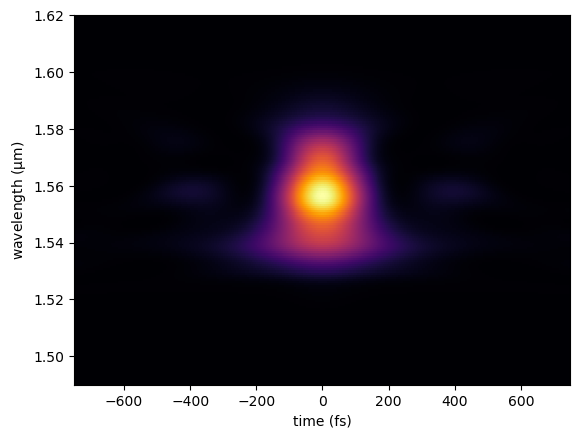

In [6]:
t_grid = np.arange(-750e-15, 750e-15, 1e-15)
v_grid, spctgm = pulse.calculate_spectrogram(t_grid)

fig_spctgm, ax_spctgm = plt.subplots(1, 1)
ax_spctgm.pcolormesh(t_grid * 1e15, c * 1e6 / v_grid, spctgm.T, cmap="inferno")
ax_spctgm.set_ylim(1.49, 1.62)
ax_spctgm.set_xlabel("time (fs)")
ax_spctgm.set_ylabel("wavelength ($\\mathrm{\\mu m}$)")

In [7]:
hnlf = pe.materials.Fiber()
pm1550 = pe.materials.Fiber()
pm1550.load_fiber_from_dict(pe.materials.pm1550, axis="slow")
hnlf.load_fiber_from_dict(pe.materials.hnlf_5p7_pooja, axis="slow")

model_pm1550 = pm1550.generate_model(pulse)
dz = pe.utilities.estimate_step_size(model_pm1550, local_error=1e-6)
result_pm1550 = model_pm1550.simulate(
    5.5e-2,
    dz=dz,
    local_error=1e-6,
    n_records=250,
    plot=None,
)

model_hnlf = hnlf.generate_model(result_pm1550.pulse_out, t_shock=None)
dz = pe.utilities.estimate_step_size(model_hnlf, local_error=1e-6)
result_hnlf = model_hnlf.simulate(
    5e-2,
    dz=dz,
    local_error=1e-6,
    n_records=250,
    plot=None,
)

In [8]:
(ind_1450_25nm,) = np.logical_and(
    (1450 - 12.5) < pulse.wl_grid * 1e9, pulse.wl_grid * 1e9 < (1450 + 12.5)
).nonzero()

(ind_1450_50nm,) = np.logical_and(
    (1450 - 25) < pulse.wl_grid * 1e9, pulse.wl_grid * 1e9 < (1450 + 25)
).nonzero()

(ind_1800_25nm,) = np.logical_and(
    (1800 - 12.5) < pulse.wl_grid * 1e9, pulse.wl_grid * 1e9 < (1800 + 12.5)
).nonzero()

(ind_1700nm_lp,) = (pulse.wl_grid * 1e9 > 1700).nonzero()

# %% ----- power @ 1450 and 1800 nm
p_v = result_hnlf.p_v

pwr_1450_25nm = (
    simpson(p_v[:, ind_1450_25nm], pulse.v_grid[ind_1450_25nm]) * 200e6 * 1e3
)
pwr_1450_50nm = (
    simpson(p_v[:, ind_1450_50nm], pulse.v_grid[ind_1450_50nm]) * 200e6 * 1e3
)
pwr_1700_lp = simpson(p_v[:, ind_1700nm_lp], pulse.v_grid[ind_1700nm_lp]) * 200e6 * 1e3
pwr_1800_25nm = (
    simpson(p_v[:, ind_1800_25nm], pulse.v_grid[ind_1800_25nm]) * 200e6 * 1e3
)


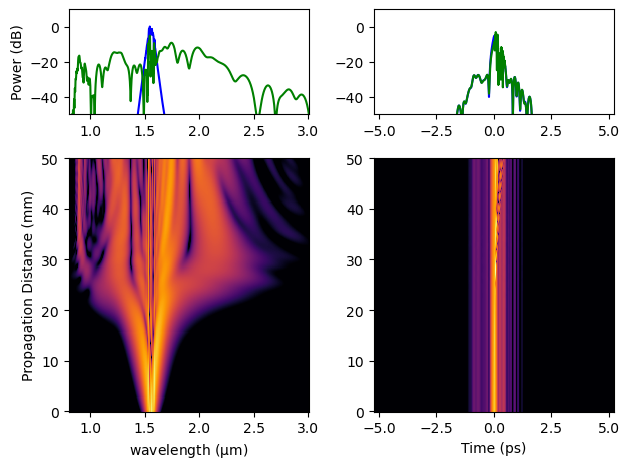

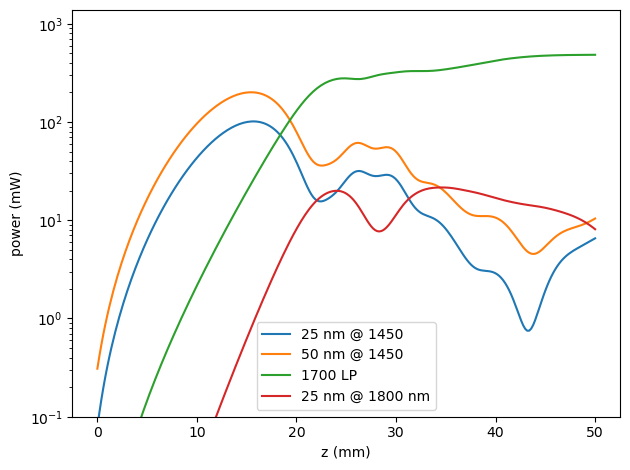

In [10]:
fig_2d, ax_2d = result_hnlf.plot("wvl")
# ax_2d[1, 0].axhline(20, color="C2", linestyle="--")

ind_end = np.argmin(abs(result_hnlf.z - 0.02))
p_v_out = result_hnlf.p_v[ind_end]

# norm = p_v_out.max()
# fig_out, ax_out = plt.subplots(1, 1)
# ax_out.semilogy(pulse.wl_grid * 1e6, p_v_out / norm)
# ax_out.set_ylim(ymin=1e-2)
# ax_out.set_xlim(1.2, 1.9)
# ax_out.set_xlabel("wavelength ($\\mathrm{\\mu m}$)")
# fig_out.tight_layout()

fig_pwr, ax_pwr = plt.subplots(1, 1)
# ax_pwr.plot(result_hnlf.z * 1e3, pwr_1450_25nm, label="25 nm @ 1450")
# ax_pwr.plot(result_hnlf.z * 1e3, pwr_1450_50nm, label="50 nm @ 1450")
# ax_pwr.plot(result_hnlf.z * 1e3, pwr_1700_lp, label="1700 LP")
# ax_pwr.plot(result_hnlf.z * 1e3, pwr_1800_25nm, label="25 nm @ 1800 nm")
ax_pwr.semilogy(result_hnlf.z * 1e3, pwr_1450_25nm, label="25 nm @ 1450")
ax_pwr.semilogy(result_hnlf.z * 1e3, pwr_1450_50nm, label="50 nm @ 1450")
ax_pwr.semilogy(result_hnlf.z * 1e3, pwr_1700_lp, label="1700 LP")
ax_pwr.semilogy(result_hnlf.z * 1e3, pwr_1800_25nm, label="25 nm @ 1800 nm")
ax_pwr.set_xlabel("z (mm)")
ax_pwr.set_ylabel("power (mW)")
ax_pwr.legend(loc="best")
ax_pwr.set_ylim(ymin=10**-1)
fig_pwr.tight_layout()